In [1]:
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
import copy
import networkx as nx
import matplotlib.pyplot as plt

from utilities import *
from functionality_4 import *

In [2]:
interval = [1300050000, 1300055000]
dataset_graphs = get_dataset_graphs(*interval)

retrieve the first dataset from the disk


  0%|          | 0/17823525 [00:00<?, ?it/s]

retrieve the second dataset from the disk


  0%|          | 0/25405374 [00:00<?, ?it/s]

retrieve the third dataset from the disk


  0%|          | 0/20268151 [00:00<?, ?it/s]

In [2]:
class Queue():
    '''
    priority queue
    '''
    
    def __init__(self, maxsize = 10**4):
        """
        internally we save it as a simple list
        and we keep track of the indices of the start and the end of the queue
        """
        
        self.size = maxsize + 1              # we keep the last element free to better manage the indices
        self.basic_list = [0] * self.size    # this list will contain the actual queue
        self.front = 0                       # the index of the front of the queue
        self.back = 0                        # the index of the first free index of the queue
    
    def empty(self):
        '''
        check if the queue is empty
        '''
        return( self.front == self.back )
    
    @property
    def occupied_space(self):
        '''
        returns the occupied space in the queue
        '''
        return((self.back - self.front)%self.size)
    
    @property
    def remaining_space(self):
        '''
        returns the space remained in the queue
        '''
        return(self.size - 1 - self.occupied_space)
    
    def resize(self):
        '''
        resizes the queue
        '''
        # we double the size of the queue
        maxsize = (self.size - 1) * 2
        newsize = maxsize + 1
        newlist = [0] * newsize
        occupied_space = self.occupied_space
        for i in range(occupied_space):
            newlist[i] = self.get()
        
        self.size = newsize
        self.basic_list = newlist
        self.front = 0
        self.back = occupied_space
        
        return
    
    def put(self, element):
        '''
        insert element at the end of the queue
        '''
        if self.remaining_space > 0:
            self.basic_list[self.back] = element
            self.back = (self.back + 1) % self.size
        else:
            self.resize()
            self.put(element)
    
    def pick(self):
        '''
        return the first element of the queue
        '''
        if not self.empty():
            return(self.basic_list[self.front])
        else:
            raise RuntimeError('Trying to get the first element of an empty queue')
    
    def get(self):
        '''
        return the first element of the queue and removes it
        '''
        if not self.empty():
            front_element = self.basic_list[self.front]
            self.front = (self.front + 1) % self.size
            return(front_element)
        else:
            raise RuntimeError('Trying to dequeue from an empty queue')

In [3]:
q = Queue(5)
print(q.empty())
q.put(8)
q.put('culo')
print(q.pick())
print(q.get())
q.put(42)
print(q.remaining_space, q.occupied_space)
q.resize()
print(q.remaining_space, q.occupied_space, q.basic_list)

True
8
8
3 2
8 2 ['culo', 42, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [43]:
a = {1:4, 2:3.5}
sum(a.values())

7.5

Thanks to the hashing functions implementation of dictionaries in Python we can know efficiently if a node or edge already exists and we can easily access the neighbours of every node. We preferred dictionaries over sets because dictionaries mantain the insertion order (since Python 3.7).

In [4]:
# (global) weight parameters
a2q_weight = 0.5
c2a_weight = 0.2
c2q_weight = 0.3

# (global) datasets paths
filename_a2q = 'data/sx-stackoverflow-a2q.txt'
filename_c2a = 'data/sx-stackoverflow-c2a.txt'
filename_c2q = 'data/sx-stackoverflow-c2q.txt'

# (global) lenght of every dataset
dataset_lenght = {filename_a2q : 17823525, filename_c2a : 25405374, filename_c2q : 20268151}

class DiGraph():
    '''
    basic directed graph
    '''
    
    def __init__(self, default_attribute = None):
        """
        internally we save it both as an adjacency list, as a list of edges,
        and as a 'reverse' adjacency list for faster computation
        """
        
        # we use default dictionaries to be able to easily insert new nodes and edges
        # without overwriting and eventual already existing edge
        
        def default_None_dict():
            return defaultdict(lambda : default_attribute)
        
        self.edges_list = defaultdict(lambda : default_attribute)   # dictionary with (directed) edges as keys and a default dummy value
        
        self.adjacency = defaultdict(default_None_dict)             # dictionary with nodes as keys and dictionary as default value
                                                                    # the default value dictionary is a default dictionary that contains
                                                                    # neighbours as keys and a default dummy value
                
        self.distant_neighbours = defaultdict(default_None_dict)    # dictionary with nodes as keys and dictionary as default value
                                                                    # the default value dictionary is a default dictionary that contains
                                                                    # all the nodes that have the considered one as neighbours as keys
                                                                    # and a default dummy value
                
    
    @property
    def graph_type(self):
        return 'Directed Graph'
    
    def __repr__(self):
        """"""
        return 'DiGraph()'
    
    def __getitem__(self, key):
        '''
        G[i] are the neighbours of the node i
        '''
        return list(self.adjacency[key].keys())
    
    def add_node(self, node):
        '''
        adds a node in the graph
        '''
        self.adjacency[node]           # thanks to the defaultdict we just need to call
        self.distant_neighbours[node]  # a key to insert the node
    
    @property
    def nodes(self):
        '''
        returns the list of nodes
        '''
        return list(self.adjacency.keys())
    
    @property
    def edges(self):
        '''
        returns the list of edges
        '''
        return list(self.edges_list.keys())
    
    def adj(self):
        '''
        returns the adjacency list
        We convert the dictionary structure to as simple dictionary of lists
        '''
        return(dict(map(lambda x: (x[0], list(x[1].keys())), self.adjacency.items())))
    
    def add_edge(self, edge0, edge1):
        '''
        adds an edge in the graph
        '''
        # add the terminal nodes if they don't exist
        self.add_node(edge0)
        self.add_node(edge1)
        
        # add the edge
        self.adjacency[edge0][edge1]
        self.distant_neighbours[edge1][edge0]
        self.edges_list[(edge0, edge1,)]
    
    @property
    def n_nodes(self):
        '''
        number of nodes
        '''
        return len(self.adjacency)
    
    @property
    def n_edges(self):
        '''
        number of edges
        '''
        return len(self.edges_list)
    
    @property
    def get_average_links(self):
        '''
        average number of links per node
        '''
        return self.n_edges / self.n_nodes
    
    @property
    def get_density(self):
        '''
        density of a directed graph
        '''
        possible_edges = self.n_nodes * (self.n_nodes - 1)   # number of all possible edges
        return self.n_edges / possible_edges
    
    @property
    def isDense(self):
        '''
        we define a graph as dense if its density is at least 0.5
        '''
        is_dense = self.get_density >= 0.5
        return is_dense
    
    @property
    def isSparse(self):
        '''
        we define a graph as sparse if it's not dense
        '''
        return (not self.isDense)
    
    def add_edges_from(self, iterable):
        '''
        add edges from an iterable
        '''
        for edge in iterable:
            self.add_edge(*edge)
    
    def remove_edge(self, edge):
        '''
        removes the input edge from the graph
        '''
        self.adjacency[edge[0]].pop(edge[1])
        self.distant_neighbours[edge[1]].pop(edge[0])
        return(self.edges_list.pop(edge))
    
    def remove_node(self, node):
        '''
        removes the input node from the graph
        '''
        # removes all outgoing edges
        for arrive in self.adjacency[node].keys():
            self.edges_list.pop((node, arrive))
            self.distant_neighbours[arrive].pop(node)
        
        # removes all ingoing edges
        for start in self.distant_neighbours[node].keys():
            self.edges_list.pop((start, node))
            self.adjacency[start].pop(node)
        
        # removes the node
        self.distant_neighbours.pop(node)
        self.adjacency.pop(node)
    
    def to_nx(self):
        '''
        converts a DiGraph() to a networkX digraph
        '''
        DG = nx.DiGraph()
        DG.add_nodes_from(self.adjacency.keys())
        DG.add_edges_from(self.edges_list.keys())
        return(DG)
    
    
class weightedDiGraph(DiGraph):
    '''
    weighted directed graph
    '''
    
    def __init__(self):
        '''
        we initialize the weighted digraph as a digraph with default attribute 0
        so the values in our default dictionaries will be the weight of the edges
        '''
        super().__init__( 0 )
    
    
    def __repr__(self):
        """"""
        return 'weightedDiGraph()'
    
    @property
    def graph_type(self):
        return 'Weighted Directed Graph'
    
    def __getitem__(self, key):
        '''
        G[i] are the tuples (neighbours, weight) of the node i
        '''
        return dict(self.adjacency[key])
    
    @property
    def edges(self):
        '''
        returns the list of tuples (edge, weight)
        '''
        return list(self.edges_list.items())
    
    def adj(self):
        '''
        returns the adjacency list
        We convert the dictionary structure to as simple dictionary of lists
        '''
        return(dict(map(lambda x: (x[0], dict(x[1])), self.adjacency.items())))
    
    def add_edge(self, edge0, edge1, weight):
        '''
        adds a weighted edge in the graph
        if the edge already exists, we sum the weights
        '''
        # add the terminal nodes if they don't exist       
        self.add_node(edge0)
        self.add_node(edge1)
        
        # add the edge
        self.adjacency[edge0][edge1] += weight            # thanks to the default dictionaries we just need
        self.distant_neighbours[edge1][edge0] += weight   # to add the weight to the existing one
        self.edges_list[(edge0, edge1)] += weight         # (where the default is 0 if the edge does not exist)
    
    def union(self, another_weightedDiGraph):
        '''
        joins the graph with an input weighted graph
        (if an edge exists it adds the weight, otherwise it adds the edges)
        '''
        for edge, weight in another_weightedDiGraph.edges:
            self.add_edge(*edge, weight)
    
    def undirected_edges(self):
        '''
        returns the set of all the edges (considering (a,b) and (b,a) as the same edge)
        '''
        undirected_edges_list = set()
        for a,b in self.edges_list.keys():
            if (b,a) in self.edges_list.keys():
                if not ((a,b) in undirected_edges_list or (b,a) in undirected_edges_list):
                    undirected_edges_list.add((a,b))
        
        return(undirected_edges_list)
    
    def to_nx(self):
        '''
        converts a weightedDiGraph() to a networkX weighted digraph
        '''
        DG = nx.DiGraph()
        DG.add_nodes_from(self.adjacency.keys())
        DG.add_weighted_edges_from([(*edge,weight) for edge, weight in self.edges_list.items()])
        return(DG)
    
    
class MultiDiGraph():
    '''
    basic multidigraph class
    '''
    
    def __init__(self, default_attribute = None):
        """
        internally we just save it as a list of edges since this is the way in which our datasets are coded
        (and we don't need to actually use this class other than for the generation of the digraph)
        """
        
        # we use default dictionaries to be able to easily insert new edges
        # and to keep the insertion ordering (which is gonna be timestamp based)
        
        
        self.edges_list = defaultdict(lambda : default_attribute)   # dictionary with (directed) edges as keys and a default dummy value
    
    
    def __repr__(self):
        """"""
        return 'DiMultiGraph()'
    
    @property
    def graph_type(self):
        return 'Directed MultiGraph'
    
    @property
    def edges(self):
        '''
        returns the list of edges
        '''
        return list(self.edges_list.keys())
    
    @property
    def n_edges(self):
        '''
        number of edges
        '''
        return len(self.edges_list)
    
    def add_edges_from(self, iterable):
        '''
        add edges from an iterable
        '''
        for edge in iterable:
            self.add_edge(*edge)
    
    def add_edge(self, edge0, edge1, timestamp):
        '''
        adds an edge in the graph
        '''
        self.edges_list[(edge0, edge1, timestamp)]
    
    def get_graph(self, filename, start_time = 0, end_time = 3000000000):
        """
        builds the multidigraph from an input file
        (selecting just the edges in the input interval, by default all edges are taken)
        
        the format for every row is user1 user2 timestamp
        where the rows are ordered by timestamp
        """
        
        with open(filename, 'r') as file:
            for row in tqdm(file, total = dataset_lenght[filename]):
                # process every row
                row = row.strip().split()
                
                # convert each element to integers
                start_node, end_node, timestamp = list(map(int, row))
                
                # only consider edges within a certain time interval
                if timestamp >= start_time and timestamp <= end_time:
                    self.add_edge(start_node, end_node, timestamp)
    
    
    def get_DiGraph_from_interval(self, start_time = None, end_time = None, weight = 1):
        '''
        builds a digraph that contains only the selected time interval
        (one should be sure to select an interval that is actually contained in the current graph)
        '''
        
        # if no interval is passed we take the whole graph
        if start_time == None:
            start_time = self.edges[0][2]
        if end_time == None:
            end_time = self.edges[-1][2]
        
        
        final_graph = weightedDiGraph()
        start_edge = search_timestamp(self.edges, start_time, mode = 'start')  # returns the index of the smallest edge
                                                                               # with a timestamp bigger or equal than start_time
        
        end_edge = search_timestamp(self.edges, end_time, mode = 'end')        # returns the index of the smallest edge
                                                                               # with a timestamp smaller than end_time
        
        # build the final graph
        for edge in self.edges[start_edge : end_edge]:
            final_graph.add_edge(*(edge[0:2]), weight)
        
        return(final_graph)
    





def search_timestamp(edges_list, time, mode):
    '''
    finds the timed edge in edges_list that is closest (based on the mode)
    to the input time
    
    if mode == 'start' the function returns the index of the smallest edge
    with a timestamp bigger or equal than the input time
    
    if mode == 'end' the function returns the index of the smallest edge
    with a timestamp smaller than the input time
    '''
    
    # basic checks on the input time
    if mode == 'start':
        if edges_list[0][2] >= time:
            return(0)
        elif edges_list[-1][2] < time:
            raise ValueError('Start time too high in search_timestamp()')
    elif mode == 'end':
        if edges_list[0][2] > time:
            raise ValueError('End time too low in search_timestamp()')
        elif edges_list[-1][2] <= time:
            return(len(edges_list))
    else:
        raise ValueError('Third argument in search_timestamp() must be either "start" or "end"')
    
    
    start_idx = 0
    end_idx = len(edges_list)
    
    # since the input edge list is ordered by timestamp
    # we implemented a binary search to find the index that we want
    
    # we keep two indices and progressively reduce the span of the search
    while (end_idx - start_idx) > 1:
        
        # take the middle of the current array
        middle_idx = (end_idx + start_idx)//2
        
        # select the interesting half of the current array
        if edges_list[middle_idx][2] < time:
            start_idx = middle_idx
            
        elif edges_list[middle_idx][2] > time:
            end_idx = middle_idx
            
        else: # if we found exactly the timestamp that we want we stop the search
            
            if mode == 'start':
                while (edges_list[middle_idx][2] == time):
                    middle_idx -= 1
                start_idx = middle_idx + 1
                return(start_idx)
            else:
                while (edges_list[middle_idx][2] == time):
                    middle_idx += 1
                start_idx = middle_idx
                return(start_idx)
    
    start_idx+=1
    
    return(start_idx)


def get_total_graph(start_time = 0, end_time = 3000000000):  # time limits of our datasets
    '''
    This function takes in input an interval of time and returns the
    "total" weighted digraph associated with this interval of time
    '''
    
    # MAGARI QUI POTREMMO PRENDERE IN INPUT OGGETTI TIMESTAMP E CONVERTIRLI IN EPOCH TIME
    
    # the weight parameters
    global a2q_weight
    global c2a_weight
    global c2q_weight
    
    # the datasets paths
    global filename_a2q
    global filename_c2a
    global filename_c2q
    
    # retrieve the first dataset from the disk
    print('retrieve the first dataset from the disk')
    dataset_graph = MultiDiGraph()
    dataset_graph.get_graph(filename_a2q, start_time = start_time, end_time = end_time)
    
    # select the time interval in the first dataset and build the weighted graph
    print('select the time interval in the first dataset')
    total_graph = dataset_graph.get_DiGraph_from_interval(start_time = start_time, end_time = end_time, weight = a2q_weight)
    
    # retrieve the second dataset from the disk
    print('retrieve the second dataset from the disk')
    dataset_graph = MultiDiGraph()
    dataset_graph.get_graph(filename_c2a, start_time = start_time, end_time = end_time)
    
    # join the second and the first dataset
    print('join the second and the first dataset')
    total_graph.union(dataset_graph.get_DiGraph_from_interval(start_time = start_time, end_time = end_time, weight = c2a_weight))
    
    # retrieve the third dataset from the disk
    print('retrieve the third dataset from the disk')
    dataset_graph = MultiDiGraph()
    dataset_graph.get_graph(filename_c2q, start_time = start_time, end_time = end_time)
    
    # join the third and the other two
    print('join the third and the other two')
    total_graph.union(dataset_graph.get_DiGraph_from_interval(start_time = start_time, end_time = end_time, weight = c2q_weight))
    
    return(total_graph)

Prova DiGraph()

In [10]:
prova = DiGraph()
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_node(7)
prova.add_node('7')
prova.add_node(42)
prova.add_node('la risposta')
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_edge(7, '7')
prova.add_edge(7, '7')
prova.add_edge('la risposta', 42)
prova.add_edge('la risposta', 'culo')
print('Lati correnti', prova.edges)
print('Nodi correnti', prova.nodes)
print('Lista di adiacenza', prova.adj())
print('Le risposte sono', prova['la risposta'])
print('Questo grafo è un', prova.graph_type)
print('Ci sono', prova.n_nodes, 'nodi e', prova.n_edges, 'lati')
print('Il numero medio di link è', prova.get_average_links)
print(prova)

Lista di adiacenza {}
Nodi correnti []
Lista di adiacenza {7: [], '7': [], 42: [], 'la risposta': []}
Nodi correnti [7, '7', 42, 'la risposta']
Lati correnti [(7, '7'), ('la risposta', 42), ('la risposta', 'culo')]
Nodi correnti [7, '7', 42, 'la risposta', 'culo']
Lista di adiacenza {7: ['7'], '7': [], 42: [], 'la risposta': [42, 'culo'], 'culo': []}
Le risposte sono [42, 'culo']
Questo grafo è un Directed Graph
Ci sono 5 nodi e 3 lati
Il numero medio di link è 0.6
DiGraph()


Prova WeightedDiGraph()

In [17]:
prova = weightedDiGraph()
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_node(7)
prova.add_node('7')
prova.add_node(42)
prova.add_node('la risposta')
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_edge(7, '7', 1)
prova.add_edge(7, '7', 3)
prova.add_edge('la risposta', 42, 42)
prova.add_edge('la risposta', 'culo', 17)
print('Lati correnti', prova.edges)
print('Nodi correnti', prova.nodes)
print('Lista di adiacenza', prova.adj())
print('Le risposte sono', prova['la risposta'])
print('Questo grafo è un', prova.graph_type)
print('Ci sono', prova.n_nodes, 'nodi e', prova.n_edges, 'lati')
print('Il numero medio di link è', prova.get_average_links)
print(prova)

Lista di adiacenza {}
Nodi correnti []
Lista di adiacenza {7: {}, '7': {}, 42: {}, 'la risposta': {}}
Nodi correnti [7, '7', 42, 'la risposta']
Lati correnti [((7, '7'), 4), (('la risposta', 42), 42), (('la risposta', 'culo'), 17)]
Nodi correnti [7, '7', 42, 'la risposta', 'culo']
Lista di adiacenza {7: {'7': 4}, '7': {}, 42: {}, 'la risposta': {42: 42, 'culo': 17}, 'culo': {}}
Le risposte sono {42: 42, 'culo': 17}
Questo grafo è un Weighted Directed Graph
Ci sono 5 nodi e 3 lati
Il numero medio di link è 0.6
weightedDiGraph()


In [5]:
prova2 = weightedDiGraph()
prova2.add_node(84)
prova2.add_node('9')
prova2.add_node(173)
prova2.add_node('le risposte')
prova2.add_edge(84, '7', 1)
prova2.add_edge(7, '7', 92)
prova2.add_edge('le risposte', 42, 42)
prova2.add_edge('le risposte', 'culo', 17)
prova2.add_edge('culo', 'la risposta', 91)
print('Lati correnti', prova2.edges)
print('Nodi correnti', prova2.nodes)
print('Lista di adiacenza', prova2.adj())
print('Le risposte sono', prova2['la risposta'])
print('Questo grafo è un', prova2.graph_type)
print('Ci sono', prova2.n_nodes, 'nodi e', prova2.n_edges, 'lati')
print('Il numero medio di link è', prova2.get_average_links)
print(prova2)

Lati correnti [((84, '7'), 1), ((7, '7'), 92), (('le risposte', 42), 42), (('le risposte', 'culo'), 17), (('culo', 'la risposta'), 91)]
Nodi correnti [84, '9', 173, 'le risposte', '7', 7, 42, 'culo', 'la risposta']
Lista di adiacenza {84: {'7': 1}, '9': {}, 173: {}, 'le risposte': {42: 42, 'culo': 17}, '7': {}, 7: {'7': 92}, 42: {}, 'culo': {'la risposta': 91}, 'la risposta': {}}
Le risposte sono {}
Questo grafo è un Weighted Directed Graph
Ci sono 9 nodi e 5 lati
Il numero medio di link è 0.5555555555555556
weightedDiGraph()


In [6]:
prova2.union(prova)
print('Lati correnti', prova2.edges)
print('Nodi correnti', prova2.nodes)
print('Lista di adiacenza', prova2.adj())
print('Le risposte sono', prova2['la risposta'])
print('Questo grafo è un', prova2.graph_type)
print('Ci sono', prova2.n_nodes, 'nodi e', prova2.n_edges, 'lati')
print('Il numero medio di link è', prova2.get_average_links)
print(prova2)

Lati correnti [((84, '7'), 1), ((7, '7'), 96), (('le risposte', 42), 42), (('le risposte', 'culo'), 17), (('culo', 'la risposta'), 91), (('la risposta', 42), 42), (('la risposta', 'culo'), 17)]
Nodi correnti [84, '9', 173, 'le risposte', '7', 7, 42, 'culo', 'la risposta']
Lista di adiacenza {84: {'7': 1}, '9': {}, 173: {}, 'le risposte': {42: 42, 'culo': 17}, '7': {}, 7: {'7': 96}, 42: {}, 'culo': {'la risposta': 91}, 'la risposta': {42: 42, 'culo': 17}}
Le risposte sono {42: 42, 'culo': 17}
Questo grafo è un Weighted Directed Graph
Ci sono 9 nodi e 7 lati
Il numero medio di link è 0.7777777777777778
weightedDiGraph()


Prova MultiDiGraph()

In [7]:
prova = MultiDiGraph()
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_node(7)
prova.add_node('7')
prova.add_node(42)
prova.add_node('la risposta')
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_edge(7, '7', 7)
prova.add_edge('la risposta', 42, 42)
prova.add_edge('la risposta', 'culo', 45)
prova.add_edge(7, '7', 98)
print('Lati correnti', prova.edges)
print('Nodi correnti', prova.nodes)
print('Lista di adiacenza', prova.adj())
print('Le risposte sono', prova['la risposta'])
print('Questo grafo è un', prova.graph_type)
print('Ci sono', prova.n_nodes, 'nodi e', prova.n_edges, 'lati')
print('Il numero medio di link è', prova.get_average_links)
print(prova)

Lista di adiacenza {}
Nodi correnti []
Lista di adiacenza {7: [], '7': [], 42: [], 'la risposta': []}
Nodi correnti [7, '7', 42, 'la risposta']
Lati correnti [(7, '7', 7), ('la risposta', 42, 42), ('la risposta', 'culo', 45), (7, '7', 98)]
Nodi correnti [7, '7', 42, 'la risposta', 'culo']
Lista di adiacenza {7: [('7', 7), ('7', 98)], '7': [], 42: [], 'la risposta': [(42, 42), ('culo', 45)], 'culo': []}
Le risposte sono [(42, 42), ('culo', 45)]
Questo grafo è un Directed MultiGraph
Ci sono 5 nodi e 4 lati
Il numero medio di link è 0.8
DiMultiGraph()


In [107]:
wow = prova.get_DiGraph_from_interval(start_time = 41.1, end_time = 45, weight = 1)
print(wow.adj())
print(wow.edges)

{42: {}, 'la risposta': {42: 1, 'culo': 1}, 'culo': {}}
[(('la risposta', 42), 1), (('la risposta', 'culo'), 1)]


In [116]:
filename = 'data/sx-stackoverflow-a2q.txt'
prova_dataset = MultiDiGraph()
prova_dataset.get_graph(filename)
woah1 = prova_dataset.get_DiGraph_from_interval(start_time = 1200000000, end_time = 1300000000, weight = 1)

0it [00:00, ?it/s]

In [117]:
filename = 'data/sx-stackoverflow-c2a.txt'
prova_dataset = MultiDiGraph()
prova_dataset.get_graph(filename)
woah2 = prova_dataset.get_DiGraph_from_interval(start_time = 1200000000, end_time = 1300000000, weight = 0.5)

0it [00:00, ?it/s]

In [118]:
woah1.union(woah2)

In [124]:
woah1.adj()

Questa è per prendere il grafone unito

In [7]:
# la barra di avanzamento ha un totale sbagliato,
# ci ho messo il numero più grande che poteva raggiungere tanto per avere un upper bound
# quindi è normale che si fermi prima del 100%
# è un po' poco estetico, magari poi la leviamo

# c'è una barra per ogni volta che si va a leggere il dataset dal disco
# tra le varie barre di caricamento seleziona l'intervallo di tempo e unisce i grafi
# ci mette più di quel che pensassi...
total_graph = get_total_graph(start_time = 1300050000, end_time = 1300060000)

retrieve the first dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

select the time interval in the first dataset
retrieve the second dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

join the second and the first dataset
retrieve the third dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

join the third and the other two


In [ ]:
total_graph.adj()

# Functionality 4

To solve this problem, we will going to use graph flow theory. We based our implementation and the considerations on the book "Introduction to Algorithms" by Cormen, Leiserson, Rivest, and Stein; the details and the proofs about our statement can be found there.

Given a directed weighted graph, we want to disconnect two users from each other cutting the minimum number of edges (with their weight). We will start by considering simpler cases, and we will implement an heuristic for the most general case. Before proceeding we want to make a remark: in a directed graph the statement "user A is disconnected from user B" means that there is no directed path from A to B, this implies that the fact that user A is disconnected from user B is independent of the fact that user B is disconnected from user A; our goal is to disconnect both A from B and B from A at the same time, while keeping a minimum cut on all the edges. We consider:
1. The problem of disconnecting a "source" node from a "sink" node while keeping a minimum cut on the edges
2. The problem of disconnecting a node A from a node B in a directed graph while keeping a minimum cut on the edges
3. The problem of disconnecting both a node A from a node B and node B from a node A in a directed acyclical graph while keeping a minimum cut on the edges
4. The general problem of disconnecting both a node A from a node B and node B from a node A in a directed graph while keeping a minimum cut on the edges

### 1.
The first problem in the list is easy: the max-flow min-cut theorem states that the maximum amount of flow passing from the source to the sink is equal to the total weight of the edges in the minimum cut, so, leveraging the Ford-Fulkerson method for finding the maximum flow, we can then look for the "saturated" edges (in the condition of maximum flow) that are reached first from the source and remove them; and this corresponds to a minimum cut.

### 2.
This problem is analogous to the previous one: we just miss a "source" node and a "sink" node. To solve the problem we add a source node with an edge that points to A and a large weight (virtually infinite, but every large number will be fine: we just need to be sure that it does not saturates), and a sink node with an edge that point from B to the sink and a large weight (as before). This newly obtained graph can be analyzed using the previous method, and the solution will be equivalent to the starting graph.

### 3.
We now want to disconnect both A from B and B from A, the procedure seems straightforward: disconnect A from B and B from A by applying the previous method and then join the result to get the minimum cut, this, however, may not give the optimal solution; here we give a simple example.

In [28]:
plot_counterexample()

NameError: name 'plot_counterexample' is not defined

In this case, applying the Ford Fulkerson method to the first graph means applying it to the second and to the third, and then joining the result. In the second graph the optimal solution is removing the edge from A to C, while in the second is the edge from B to C. So removing this two edges from the original graph would disconnect A and B with a total cost of of 2, but the optimal solution would be removing just the edge from C to D (with a total cost of 1.5). The problem here is that exists two paths (one from A to B and the other from B to A) that have a common edge, which is equivalent to the existence of two distinct cycles (one that contains A and not B, and another that contains B and not A) that have a common edge. So this last case would be our exact hypotesis; in this framework, as said before, to find the optimal solution we can just apply the Ford Fulkerson method twice and join the solutions.

### 4.
We did not manage to find an algorithm to solve the general problem and that does not involve checking all the possible combinations of cuts. For this reason, we provide a couple of heuristics:
* upon starting the algorithm we search for all the possible couple of cycles containing A and B, we intersect each possible pairs and collect a set of edges, we remove the one with the lighter weight, and then we repeat until there are no common edges left. At this point we can proceed as described in the previous case.
* following the idea of the flow network, we imagine two distinct type of flow (with two sources and two sinks) that run in the same pipes, one from A to B and the other from B to A; we can try to maximize this flow by splitting the residual capacity of a common augmenting path between the two flows. This method however may depend  on the actual order in which we find the augmenting paths, and may not bring to the optimal solution. Moreover, it is easy to see that in this case the saturated paths are not necessarily those of a minimum cut.
* joining the last two methods, one may try to remove a saturated edge (as found with the previous method) if it is part of a common cycle (as above), and then repeating until no cycles remains.
* another possibility could be halving the capacity of the edges in the common cycles, and running the algorithm as if there were no common edges. At this point one could remove the common edges if they are saturated and then repeat the algorithm to find the cut. One may want to study more in detail the problem.
* our last proposal is just to ignore the problem of the cycles and proceed with the algorithm of the previous case.

These are all simple heuristic, and we can easily see some of them fail; we did not feel like neither spending more time on it, nor adding another layer of complexity to the algorithm, so we decided to go for this last choice. Since the graph will be pretty big, we hope that there won't be many common cycle edges that can give problems to our optimal solution. Moreover, specifically to not add complexity to the algorithm, we decided to implement the Edmonds-Karp version of the Ford Fulkerson method for finding the maximum flow, instead of a faster Push Relabel or Push to Front algorithms.

In [5]:
def functionality4(interval1, interval2, user1, user2):
    '''
    functionality 4:
    given two input intervals and two users, we build two associated graphs,
    we join them and we search for the smallest cut that disconnects the two users
    '''
    
    # get the total graph
    total_graph = get_total_graph(*interval1)
    total_graph.union(get_total_graph(*interval2))
    
    # make a copy of the graph
    graph = copy.deepcopy(total_graph)
    
    # find the edges to remove
    edges = find_min_cut(graph, user1, user2)
    
    # compute the total cost of the solution
    total_cost = 0
    for edge in edges:
        total_cost += total_graph.edges_list[edge]
    
    return total_graph, total_cost, edges

def find_min_cut(graph, user1, user2):
    '''
    here we find the minimum edges to cut to disconnect the input users
    '''
    
    # we transform the graph to remove the antiparallel edges
    # as a first step to simplify the algorithm
    # 
    # and we remove the edge that connects a user to himself
    # (as they will not be relevant for the analysis of the flow)
    
    # retrieve the undirected edges
    antiparallel = graph.undirected_edges()
    removed_edges = {}
    
    # we use the fact that all the nodes are positive integers
    new_node = 0
    for a,b in antiparallel:
        # remove the edges in one of the directions
        weight = graph.remove_edge((a,b))
        
        if a != b:
            # we use negative integers to denote the added nodes
            new_node -= 1
            # we store the added node for future reference
            removed_edges[new_node] = (a,b)
            
            # we add a mock edge between a and b
            graph.add_edge(a,new_node,weight)
            graph.add_edge(new_node,b,weight)
    
    
    # we find the minimum cut from user1 to user2
    cut_1_to_2 = find_min_cut_A_to_B(graph, user1, user2)
    
    # we find the minimum cut from user1 to user2
    cut_2_to_1 = find_min_cut_A_to_B(graph, user2, user1)
    
    # we join the two cuts
    # this is the step in which we may lose the optimality
    total_edges = set.union(cut_1_to_2, cut_2_to_1)
    
    
    # among these edges, we substitute the newly added (the negative) nodes
    # and we restore the antiparallel edges for the final solution
    transformed_edges = set()
    for a,b in total_edges:
        # by construction there are no edges between two negative nodes
        if a < 0 or b < 0:
            new_node = min(a,b)
            transformed_edges.add(removed_edges[new_node])
        else:
            transformed_edges.add((a,b))
        
    return(transformed_edges)

def find_min_cut_A_to_B(graph, user1, user2):
    '''
    this function finds the minimum edge cut to disconnect
    user1 (the source) from user2 (the sink)
    '''
    # we add a 'supersource' that only connects to user1
    # and a 'supersink' that only connects to user2
    # so that the flow problem is well defined
    
    # we choose the weight of the edge from the supersource to user1 as some number
    # greater than the sum of all the outgoing weights from user1 (so that it won't affect the flow)
    source_weight = 1
    for weight in graph.adjacency[user1].values():
        source_weight += weight
    graph.add_edge('source', user1, source_weight)   # add the 'supersource'
    
    # it is sufficient to have sink_weight == source_weight for these
    # nodes to not influence the outcome of the algorithm
    sink_weight = source_weight
    graph.add_edge(user2, 'sink', sink_weight)   # add the 'supersink'
    
    # find the maximum flow in this flow problem
    flow = find_max_flow(graph)
    
    # find the minimum cut from the maximum flow
    selected_edges = find_min_cut_edges(graph, flow, source = 'source', sink = 'sink')
    
    # remove the added source and sink
    graph.remove_node('source')
    graph.remove_node('sink')
    
    return(selected_edges)

def find_max_flow(graph, source = 'source', sink = 'sink'):
    '''
    find maximum flow in the input flow problem
    
    we use edmond-karp algorithm
    '''
    # we initialize the flow dictionaries with all zeros
    # the keys of this dictionary will be the edges
    flow_dict = defaultdict(lambda : 0)
    
    # boolean variable to check if we found the maximum flow
    # (since a maximum flow is found when there are no augmenting paths)
    found_path = True
    
    while found_path:
        # search and return an augmenting path
        previous = search_augmenting_path(graph, flow_dict, source = source, sink = sink)
        
        # if the sink is not in the path, we did not find an augmenting path
        if sink not in previous.keys():
            found_path = False
        
        # if we found an augmenting path, we increase the flow accordingly
        if found_path:
            increase_flow(graph, flow = flow_dict, path = previous, source = source, sink = sink)
    
    
    return (flow_dict)

def search_augmenting_path(graph, flow, source, sink):
    '''
    this function searches an augmenting path in the residual graph
    '''
    # dictionary that will store the path
    # the keys will be the nodes of the path
    previous = {}
    
    # initialize residual graph
    residual_graph = weightedDiGraph()
    
    # we use BFS to search for a shortest path
    # (in this framework, it is sufficient to consider the residual
    #  graph as an unweighted graph)
    
    # we use a queue for BFS
    q = Queue()
    q.put(source)
    
    # BFS cycle
    while not q.empty():
        
        current_node = q.get()
        
        # we build the residual graph locally around the current node
        build_residual_graph(graph, residual_graph, current_node, flow)
        
        for node, capacity in residual_graph.adjacency[current_node].items():
            if node not in previous.keys():   # if the node is not already visited
                
                # the values associated to each path node is a dictionary
                # with two elements: the previous node in the path and the residual capacity of the edge
                previous[node] = {'previous' : current_node, 'capacity' : capacity}
                
                q.put(node)
            
            # we stop if we found the sink
            if node == sink:
                break
    
    return(previous)

def build_residual_graph(graph, residual_graph, current_node, flow):
    '''
    builds the residual graph around the input node
    '''
    
    # build the residual edges for the outgoing edges
    for node, weight in graph.adjacency[current_node].items():
        capacity = weight - flow[(current_node, node)]
        if capacity > 0:   # the edge is a residual edge only if it has positive residual capacity
            residual_graph.add_edge(current_node, node, capacity)
    
    # build the residual edges for the ingoing edges
    for node, weight in graph.distant_neighbours[current_node].items():
        capacity = flow[(node, current_node)]
        if capacity > 0:   # the edge is a residual edge only if it has positive residual capacity
            residual_graph.add_edge(node, current_node, capacity)
    
    return
    
def increase_flow(graph, flow, path, source, sink):
    '''
    increase the flow on the input augmenting path
    '''
    
    # we will run across the path backwards
    # and we stop at the source
    
    prev_node = path[sink]['previous']
    min_capacity = path[sink]['capacity']
    
    # here we build the edges that belong to the path
    # and we search for the residual capacity to add
    path_edges = [(prev_node, sink)]
    while prev_node != source:
        current_node = prev_node
        prev_node = path[prev_node]['previous']
        
        path_edges.append((prev_node, current_node))
        
        # the residual capacity is the minimum weight in the path
        if path[current_node]['capacity'] < min_capacity:
            min_capacity = path[current_node]['capacity']
    
    # now we increase the flow on all the path edges
    for edge in path_edges:
        
        if edge in graph.edges_list.keys():
            flow[edge] += min_capacity
        else:
            flow[edge] -= min_capacity
    
    return

def find_min_cut_edges(graph, flow, source, sink):
    '''
    finds the edges corresponding to the minimum cut
    using the maximum flow
    
    To find these edges we build the residual graph and we
    visit every node reachable from the source.
    Since the flow is maximum, the source and the sink are disconnected
    in the residual network.
    The minimum cut edges are then those between a visited and a non visited node.
    '''
    
    # dictionary to track the visited nodes
    visited = defaultdict(lambda : 0)
    
    # initialize the residual graph
    residual_graph = weightedDiGraph()
    
    # we use BFS to visit every reachable node
    
    # initialize the queue used in BFS
    q = Queue()
    q.put(source)
    visited[source] = 1
    
    while not q.empty():
        current_node = q.get()
        
        # we build the residual graph locally
        build_residual_graph(graph, residual_graph, current_node, flow)
        
        for node in residual_graph.adjacency[current_node].keys():
            if node not in visited.keys():
                q.put(node)
                visited[node] = 1
    
    # once every reachable node is marked as visited
    # we select the minimum cut edges
    selected_edges = set()
    for a,b in graph.edges_list.keys():
        if visited[a] ==1 and visited[b] == 0:
            selected_edges.add((a,b))
    
    return(selected_edges)

In [5]:
DG = weightedDiGraph()
DG.add_node(0)
DG.add_node(1)
DG.add_node(2)
DG.add_node(3)
DG.add_edges_from([(0,2,1), (2,3,1.5), (3,0,3), (3,1,3), (1,2,1)])

edges = find_min_cut(DG, 0, 1)

In [6]:
edges

{(0, 2), (1, 2)}

In [7]:
total_graph = get_total_graph(start_time = 1300050000, end_time = 1300060000)

retrieve the first dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

select the time interval in the first dataset
retrieve the second dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

join the second and the first dataset
retrieve the third dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

join the third and the other two


In [ ]:
total_graph.nodes

In [8]:
user1 = 413337
user2 = 436721

graph = copy.deepcopy(total_graph)
edges = find_min_cut(graph, user1, user2)
    
    
total_cost = 0
for edge in edges:
    total_cost += total_graph.edges_list[edge]
print('total cost', total_cost)

total cost 1.1


In [9]:
edges

{(413337, 436721), (436721, 413337)}

In [69]:
DG = weightedDiGraph()
DG.add_node(0)
DG.add_node(1)
DG.add_node(2)
DG.add_node(3)
DG.add_edges_from([(0,2,1), (2,3,1.5), (3,0,3), (3,1,3), (1,2,1)])

boh = DG.to_nx()

In [39]:
boh = total_graph.to_nx()

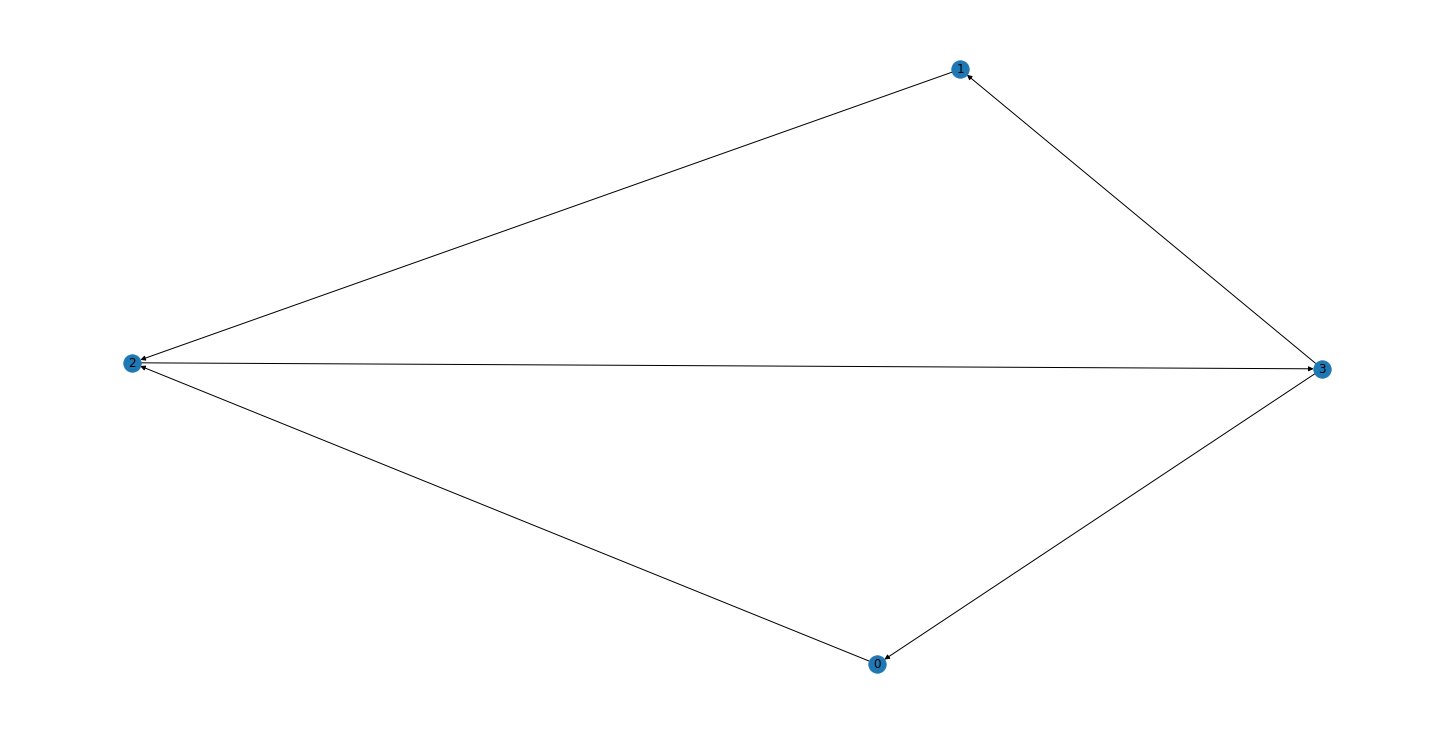

In [70]:
plt.figure(figsize = (20,10))
pos = nx.spring_layout(boh)

nx.draw(boh, pos, with_labels = True)

labels = nx.get_edge_attributes(boh,'weight')
#nx.draw_networkx_edge_labels(boh,pos,edge_labels=labels)
plt.show()

In [18]:
prova.edges_list.keys()

dict_keys([(7, '7'), ('la risposta', 42), ('la risposta', 'culo')])

In [6]:
# assumes that len(edges) > 0
def plot4(G, edges, user1, user2):
    '''
    this function shows a visualization of the links needed to be removed in order to disconnect the users

    input: NX graph,
           edges to remove,
           user1,
           user2
    '''
    
    
    # Set all edge color attribute to black
    for e in G.edges():
        G[e[0]][e[1]]['color'] = 'black'
    
    # Set color of edges of the shortest path to red
    for p in edges:
        G[p[0]][p[1]]['color'] = 'red'
    
    # Store in a list to use for drawing
    edge_color_list = [ G[e[0]][e[1]]['color'] for e in G.edges() ]
    nx.draw(G,edge_color = edge_color_list, with_labels = False)
    
    plt.show()
    
    return

interval = [1300050000, 1300060000]
user1 = 413337
user2 = 436721
graph, total_cost, edges = functionality4(interval, interval, user1, user2)

retrieve the first dataset from the disk


  0%|          | 0/17823525 [00:00<?, ?it/s]

select the time interval in the first dataset
retrieve the second dataset from the disk


  0%|          | 0/25405374 [00:00<?, ?it/s]

join the second and the first dataset
retrieve the third dataset from the disk


  0%|          | 0/20268151 [00:00<?, ?it/s]

join the third and the other two
retrieve the first dataset from the disk


  0%|          | 0/17823525 [00:00<?, ?it/s]

select the time interval in the first dataset
retrieve the second dataset from the disk


  0%|          | 0/25405374 [00:00<?, ?it/s]

join the second and the first dataset
retrieve the third dataset from the disk


  0%|          | 0/20268151 [00:00<?, ?it/s]

join the third and the other two


In [87]:
G = graph.to_nx()

In [ ]:
plot4(G, edges, user1, user2)

In [88]:
H = nx.subgraph(G, [e[0] for e in edges] + [e[1] for e in edges])
H = G

node_colors = ["green" if node in [user1, user2] else "blue" for node in H.nodes()]
node_sizes = list(map(lambda x: 200 if x=='green' else 50, node_colors))
edge_colors = ['red' if edge in edges else 'black' for edge in H.edges()]
edge_widths = list(map(lambda x: 1.5 if x=='red' else 0.3, edge_colors))



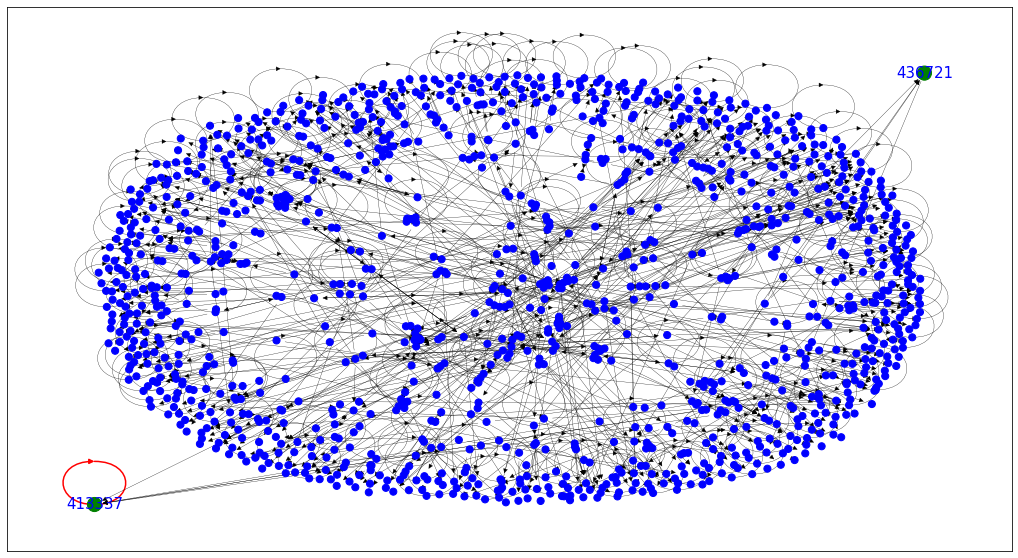

In [ ]:
plt.figure(figsize = (18,10))

pos = nx.spring_layout(H)

labels = {user1 : user1, user2 : user2}

for idx, node in enumerate(H.nodes()):
    if node == user1:
        temp1 = list(map(lambda x: x[0],pos.values()))
        temp2 = list(map(lambda x: x[1],pos.values()))
        pos[node] = (min(temp1) - 0.01, min(temp2) - 0.01)
    if node == user2:
        temp1 = list(map(lambda x: x[0],pos.values()))
        temp2 = list(map(lambda x: x[1],pos.values()))
        pos[node] = (max(temp1) + 0.01, max(temp2) + 0.01)

nx.draw_networkx_nodes(H, pos = pos, node_color = node_colors, node_size = node_sizes)
nx.draw_networkx_edges(H, pos=pos, edge_color = edge_colors, width = edge_widths)
nx.draw_networkx_labels(H,{user1 : pos[user1], user2 : pos[user2]} ,labels,font_size=15,font_color='b')
plt.show()

In [107]:
def functionality_1(dataset_graph):
    '''
    functionality 1:
    Given in input one of the 3 dataset multidigraphs
    we give in output:
        The dataset DiGraph
        Whether the graph is directed or not
        Number of users
        Number of answers/comments
        Average number of answers/comments per user
        Average number of links per user
        Density degree of the graph
        Whether the graph is sparse or dense
    '''
    global standard_interval
    
    graph = dataset_graph.get_DiGraph_from_interval(*standard_interval)
    
    graph_type = graph.graph_type
    
    n_users = graph.n_nodes
    
    n_answers_comments = graph.n_weighted_edges
    
    average_answers_comments = graph.get_average_weighted_links
    
    average_links = graph.get_average_links
    
    density = graph.get_density
    
    is_dense = graph.isDense
    
    return graph, graph_type, n_users, n_answers_comments, average_answers_comments, average_links, density, is_dense


def plot_1(graph, graph_type, n_users, n_answers_comments, average_answers_comments, average_links, density, is_dense):
    '''
    visualization for functionality 1
    '''
    
    display(HTML(f"<table class='table table-striped'> <tbody> <tr> <th scope='row'>Graph Type</th> <td>{graph_type}</td></tr> <tr> <th scope='row'>Number of users</th> <td>{n_users}</td> </tr> <tr> <th scope='row'>Number of answers/comments</th> <td>{n_answers_comments}</td> </tr>  <tr> <th scope='row'>Average number of answers/comments per user</th> <td>{'{:.2f}'.format(average_answers_comments)}</td> </tr> <tr> <th scope='row'>Average number of links per user</th> <td>{'{:.2f}'.format(average_links)}</td> </tr> <tr> <th scope='row'>Density degree of the graph</th> <td>{'{:.2e}'.format(density)}</td> </tr> <tr> <th scope='row'>Density/Sparsity</th> <td>The graph is {'Dense' if is_dense else 'Sparse'}</td> </tr> </tbody> </table>"))
    
    # convert to networkx graph for visualization
    H = graph.to_nx()
    
    # compute the node centrality for the density distribution
    normalization = H.number_of_nodes() - 1
    node_centrality = [H.degree(node)/normalization for node in H.nodes()]
    
    # renormalize the centrality between max and min
    max_centr = max(node_centrality)
    min_centr = min(node_centrality)
    node_centrality = list(map(lambda x: (x - min_centr)/(max_centr - min_centr), node_centrality))
    
    # set the colormap
    cmap = cm.get_cmap('viridis')
    
    # retrieve the node colors
    node_colors = list(map(lambda x: cmap(x), node_centrality))
    
    fig = plt.figure(figsize = (18,10))

    # add grid specifications for the color legend
    gs = fig.add_gridspec(1, 18)
    
    # the plot of the graph
    ax = fig.add_subplot(gs[:,0:17])
    
    ax.set_title('Density distribution')

    pos = nx.spring_layout(H)

    nx.draw_networkx_nodes(H, pos = pos, node_color = node_colors, ax = ax)
    nx.draw_networkx_edges(H, pos = pos, ax = ax, edge_color = 'gray')
    
    # the plot of the color legend
    ax1 = fig.add_subplot(gs[:,17])
    
    ax1.set_title('Centrality')
    
    # color gradient to plot the legend
    gradient = np.flip(np.linspace(0, 1, 256))
    gradient = np.transpose(np.vstack((gradient, gradient)))
    ax1.imshow(gradient, aspect='auto', cmap=cmap)
    
    # removing xticks from the legend
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # correctly setting the yticks in the legend
    ax1.yaxis.tick_right()
    ax1.set_yticks([0,256])
    ax1.set_yticklabels(['{:.2g}'.format(max_centr), '{:.2g}'.format(min_centr)])
    
    plt.show()
    
    return

In [108]:
from IPython.core.display import display, HTML
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

In [109]:
graph, graph_type, n_users, n_answers_comments, average_answers_comments, average_links, density, is_dense = functionality_1(dataset_graphs[0])

Graph Type,Weighted Directed Graph
Number of users,9110
Number of answers/comments,16293
Average number of answers/comments per user,1.79
Average number of links per user,1.73
Density degree of the graph,1.90e-04
Density/Sparsity,The graph is Sparse


KeyboardInterrupt: 

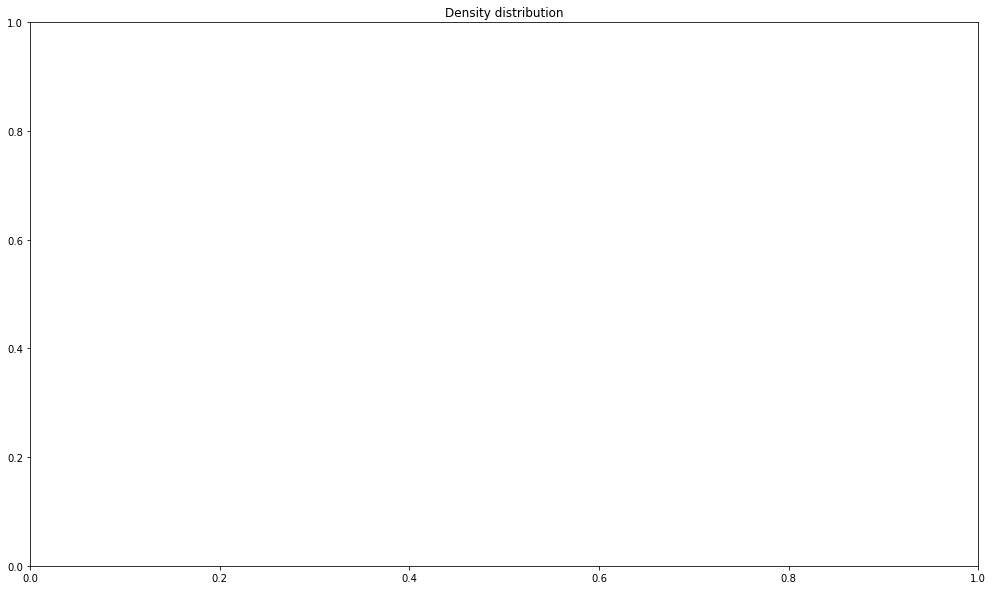

In [110]:
plot_1(graph, graph_type, n_users, n_answers_comments, average_answers_comments, average_links, density, is_dense)

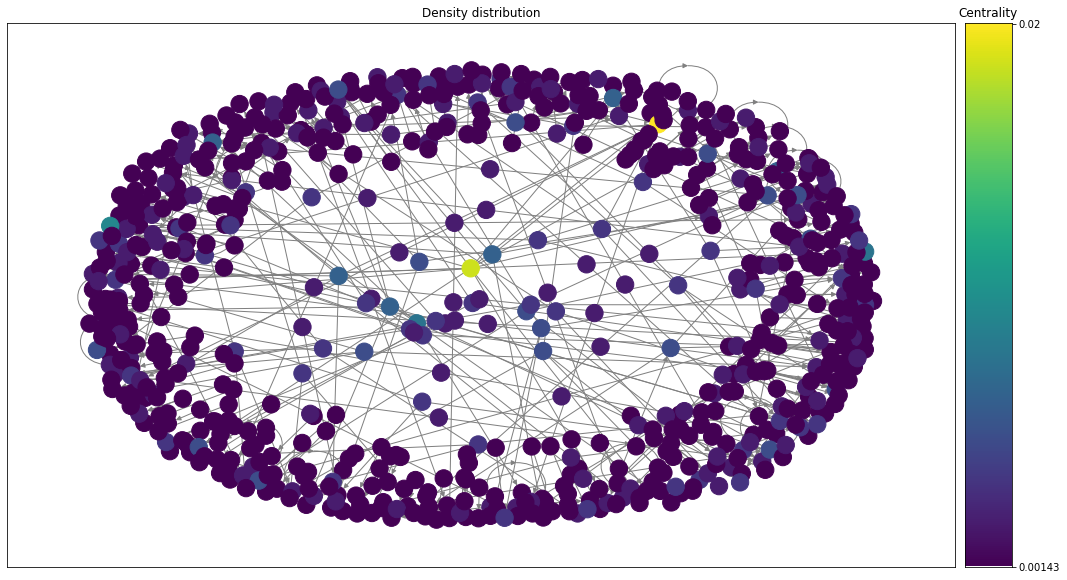

In [89]:
H = graph.to_nx()

normalization = H.number_of_nodes() - 1
node_centrality = [H.degree(node)/normalization for node in H.nodes()]
max_centr = max(node_centrality)
min_centr = min(node_centrality)

cmap = cm.get_cmap('viridis')

node_colors = list(map(lambda x: cmap( (x - min_centr)/(max_centr - min_centr)), node_centrality))

# we color-code the nodes and the edges
#node_colors = [cmap(H.degree(node)/normalization) for node in H.nodes()]
#node_colors = [cmap(np.random.rand()) for node in H.nodes()]
#node_sizes = [50 for node in H.nodes()]
#edge_colors = ['black' for edge in H.edges()]
#edge_widths = list(map(lambda x: 1.5 if x=='orange' else 0.5, edge_colors))

fig = plt.figure(figsize = (18,10))

# add grid specifications
gs = fig.add_gridspec(1, 18)

ax = fig.add_subplot(gs[:,0:17])
ax.set_title('Density distribution')

pos = nx.spring_layout(H)

nx.draw_networkx_nodes(H, pos = pos, node_color = node_colors, ax = ax)#, node_size = node_sizes)
nx.draw_networkx_edges(H, pos = pos, ax = ax, edge_color = 'gray')#= edge_colors, width = edge_widths, arrows = True)

gradient = np.flip(np.linspace(0, 1, 256))
gradient = np.transpose(np.vstack((gradient, gradient)))


ax1 = fig.add_subplot(gs[:,17])
ax1.set_title('Centrality')
ax1.imshow(gradient, aspect='auto', cmap=cmap)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.yaxis.tick_right()
ax1.set_yticks([0,256])
ax1.set_yticklabels(['{:.2g}'.format(max_centr), '{:.2g}'.format(min_centr)])



plt.show()

In [72]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    fig, ax = plt.subplots()
    ax.set_title(f'{category} colormaps', fontsize=14)
    
    name = cmap_list[0]
    ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
    ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
            transform=ax.transAxes)
    


In [90]:
max_centr

0.020028612303290415

In [31]:
cmap = cm.get_cmap('spring')

rgba = cmap()


(1.0, 0.5019607843137255, 0.4980392156862745, 1.0)


In [82]:
'{:.2f}'.format(0.254894)

'0.25'

-------------------------------------------------------------------------------------
There are 2 edges to be removed, for a total cost of 3.6666666666666665.
-------------------------------------------------------------------------------------


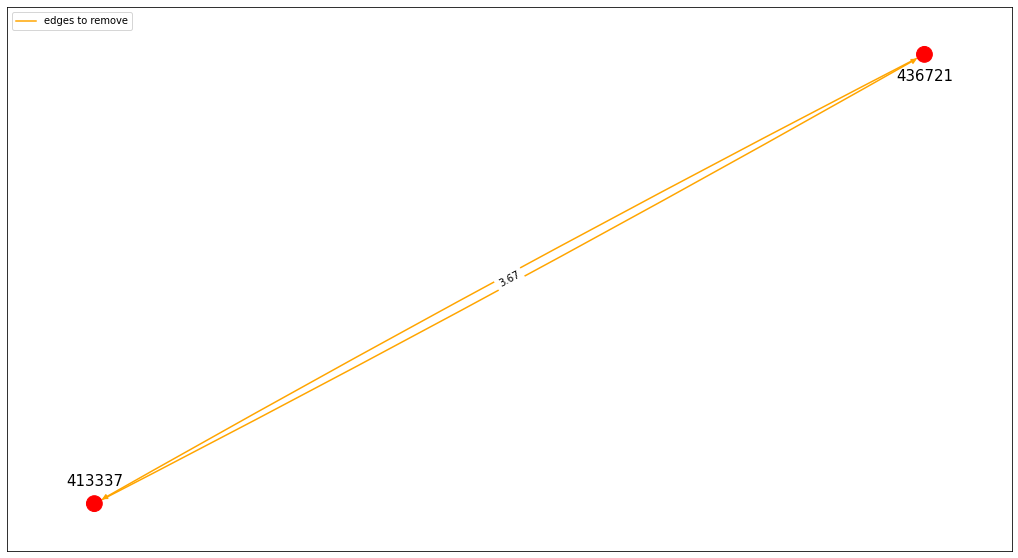

In [4]:
total_graph = weightedDiGraph()
total_graph.add_node(1)
total_graph.add_node(3)
user1 = 1
user2 = 3

# make a copy of the graph
graph = copy.deepcopy(total_graph)

# find the edges to remove
edges = find_min_cut(graph, user1, user2)

# compute the total cost of the solution
total_cost = 0
for edge in edges:
    total_cost += total_graph.edges_list[edge]

graph = total_graph
    
interval_1 = [1300050000, 1300060000]
user_1 = 413337
user_2 = 436721

interval_2 = interval_1

'''interval_1 = [
    1262301400, 
    1262312400, 
    ]

interval_2 = [
    1262312400, 
    1262324400, 
    ]

user_1 = 232279
user_2 = 1242
'''

##########################################################

graph, total_cost, edges = functionality_4(dataset_graphs, interval_1, interval_2, user_1, user_2)

plot_4(graph, edges, total_cost, user_1, user_2)

In [112]:
for path in nx.all_simple_paths(H, user_2, user_1):
    print(path)

KeyboardInterrupt: 

In [114]:
H = graph.to_nx()

# we compute all the nodes that belong to a path
# between user1 and user2 and use the induced subgraph for the visualization
all_nodes_in_between = set()
for comp in nx.weakly_connected_components(H):
    if user_1 in comp:
        H = H.subgraph(comp)
        break
        

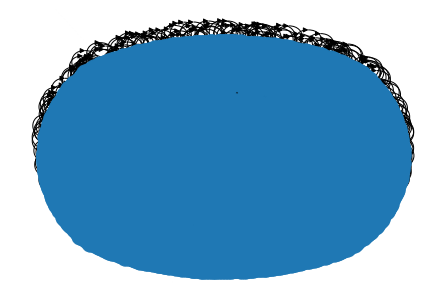

In [119]:
H = graph.to_nx()
nx.draw(H)

# BETWEENESS
In graph theory betweeness centrality is a measure of centrality based on shortest paths. Betweeness of a node $n_v$ is calculated as the summatory of the number of shortest path in which there is the node, on the total number of the total shortest path of the graph. A shortest path is the path to go from a node $n_i$ to a node $n_j$ such that the number of edges that the path passes through is minimized. Instead, if the graph is weighted, we want that the sum of the weights of the edges is minimized. The meaning of this centrality measure is how much a node stands between each other node: it evaluates the importance of a node based on its own ability to perform as a "bridge" among the nodes. The higher the measure is, the more important the node is in the graph, because it means that node is usefull to transport a very high number of information through the graph, moreover it has control over these information.

The formula we used is the normalized one:

\begin{equation}
b(v)=\sum_{i, j \in V} \frac{g_{ij}^v}{g_{ij}} \frac{2}{|V|^2 - 3|V| + 2} 
\end{equation}

in which $g_ij$ is the shortest path from the node $i$ to the node $j$, and $g^v_ij$ is the shortest path from $i$ to $j$ in which appear the node $i$, and $|V|$ is the total number of nodes in the graph.




# PAGE RANK

PageRank is an alghorithm to measure the importance of a node in a graph. It works by counting the number and quality of links to the node to determine a rough estimate of how important it is.
The algorithm was initially invented and used by Google, to help its search engines to reach more important pages for a specific query. Given a node $n_i$ this metric is defined recursively, and it is based on the value of the page rank metric of all pages that have an edge to the node itself (all the 'incoming' edge to it). A page that is linked to by many pages with high PageRank receives a high rank itself.


# DEGREE CENTRALITY

The degree centrality measure refers to the quantity of edge a node has, if the graph is directed we consider both incoming and outgoing edge.
According to this measure of centrality, higher values mean that the node is more connected: the greater is the degree of a node, and so the more connections it has, the greater its importance is. The meaning of this metric is that a node with a high degree will be more likely to communicate and communicate with other nodes. At the same time it doesn not give us information about the "centrality" of the node in the graph but only it refears to the "sociality" of the node.
We calculate the degree centrality normalized as follow:

\begin{equation}
d(i)=\frac{d_i}{|V|-1}
\end{equation}

with $d_i$ the degree of the node $i$, that is the quantity of edge incoming and outgoing of the node $i$, and $|V|$ is the total number of nodes in the graph.


# CLOSENESS CENTRALITY
Closeness centrality of a node $i$ is calculated as the sum of the length of the shortest paths between the node and all other nodes in the graph. This means that the more central a node is, the closer it is to all other nodes. This quantity takes low values for vertices that are separated from others by only a short path on average. Such vertices might have better access to information at other vertices or more direct influence on other vertices. The max value that can assume is when the graph is a list and the two nodes are at the begining and at the end of this list, intead the lower value it can take is when we consider the central node in a star graph, and so it is at the center of each pair of node, reaching all the other nodes in just one edge.


\begin{equation}
c(i)=\frac{|V|-1}{\sum_{j \in V} d(i,j)}
\end{equation}


in which $d(i, j)$ is the shortest path from the node $i$ to all the nodes $j$ in $V$, and $|V|$ is the total number of nodes in the graph.

In [95]:
import math
a = math.inf

In [97]:
math.inf!=math.inf

False

In [5]:
def pagerank_vector(graph, alpha=0.85, max_iter=100, tol=1e-03):
    
    """Get the pagerank vector for a given graph"""
    node_encoding = {}
    for idx, node in enumerate(graph.nodes):
        node_encoding[node] = idx

    # compute adjacency matrix
    P = np.zeros((graph.n_nodes, graph.n_nodes))
    for node, idx in node_encoding.items():
        total_weight = sum(graph.adjacency[node].values())
        for adjacent_node, weight in graph.adjacency[node].items():
            P[idx, node_encoding[adjacent_node]] = weight/total_weight

    # compute the transpose pagerank matrix
    P = (1 - alpha) * np.ones((graph.n_nodes, graph.n_nodes)) / graph.n_nodes + alpha * P

    # renormalize the matrix
    P = P / np.broadcast_to(np.sum(P, axis = 1)[:, np.newaxis], (graph.n_nodes, graph.n_nodes))
    
    # starting vector
    q = np.ones((graph.n_nodes, 1)) / graph.n_nodes
    
    difference = tol + 1
    i = 0
    
    while ( i < max_iter and difference > tol ):
        
        i += 1
        
        P = np.linalg.matrix_power(P, 2)
        new_q = np.matmul(P, q)
        
        difference = np.linalg.norm(new_q - q)
        
        q = new_q
        
    
    
    pagerank_vector = {}
    for node, idx in node_encoding.items():
        pagerank_vector[node] = q[idx, 0]
    return(pagerank_vector)
    

def pagerank(graph, input_node, alpha=0.85, max_iter=100, tol=1e-03):
    """Get the pagerank score for a given node"""
    
    # compute the pagerank vector
    pagerank_vec = pagerank_vector(graph, alpha = alpha, max_iter = max_iter, tol = tol)
    
    return(pagerank_vec[input_node])
    

In [8]:
p = pagerank_vector(graph)#, 232279)

In [12]:
p2 = nx.pagerank(graph.to_nx(), alpha=0.15,  max_iter=100, tol=1e-06, weight='weight')

In [237]:
a = []
for node, score in p2.items():
    a.append(score - p[node])

In [238]:
max(a)

0.0008892445054905946

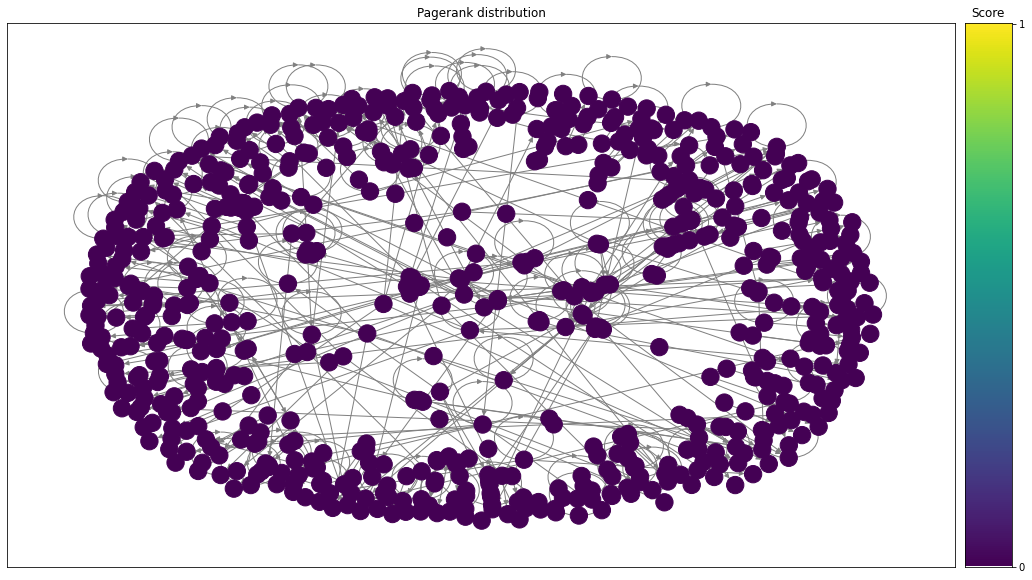

In [13]:
# convert to networkx graph for visualization
H = graph.to_nx()

p = pagerank_vector(graph)

# set the colormap
cmap = cm.get_cmap('viridis')


# retrieve the node colors
node_colors = [cmap(p[node]) for node in H.nodes()]


fig = plt.figure(figsize = (18,10))

# add grid specifications for the color legend
gs = fig.add_gridspec(1, 18)

# the plot of the graph
ax = fig.add_subplot(gs[:,0:17])

ax.set_title('Pagerank distribution')


pos = nx.spring_layout(H)


nx.draw_networkx_nodes(H, pos = pos, node_color = node_colors, ax = ax)
nx.draw_networkx_edges(H, pos = pos, ax = ax, edge_color = 'gray')

# the plot of the color legend
ax1 = fig.add_subplot(gs[:,17])

ax1.set_title('Score')

# color gradient to plot the legend
gradient = np.flip(np.linspace(0, 1, 256))
gradient = np.transpose(np.vstack((gradient, gradient)))
ax1.imshow(gradient, aspect='auto', cmap=cmap)

# removing xticks from the legend
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# correctly setting the yticks in the legend
ax1.yaxis.tick_right()
ax1.set_yticks([0,256])
ax1.set_yticklabels([1, 0])

plt.show()